In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"data/Base_Files/full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
48591,NaN,NaN,International,2020-10-05,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48592,NaN,NaN,International,2020-10-06,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48593,NaN,NaN,International,2020-10-07,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


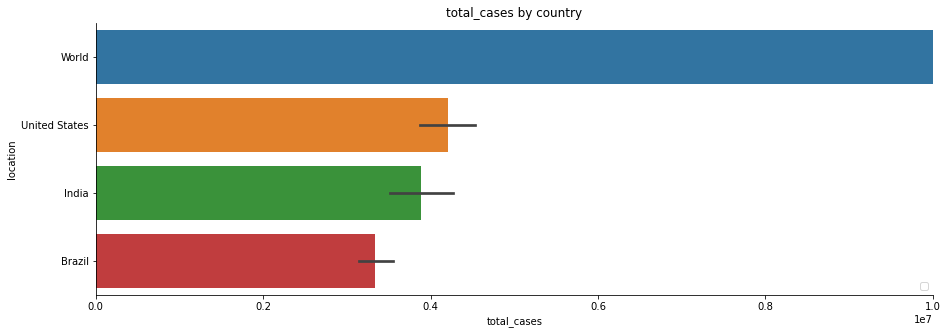

In [13]:
worldrep("total_cases",graph_long=5,val_larg=10000000)

No handles with labels found to put in legend.


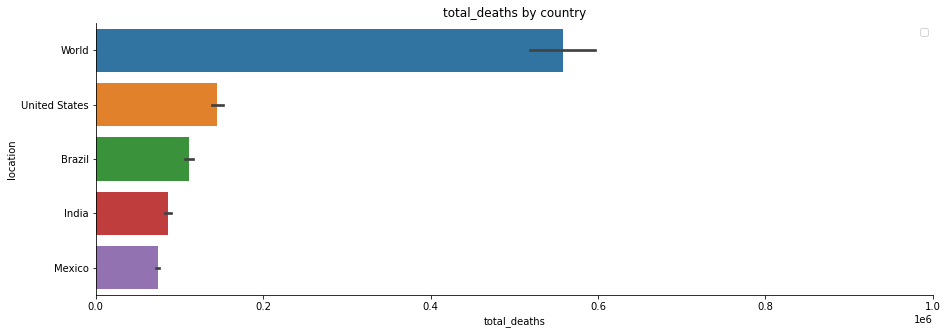

In [14]:
worldrep("total_deaths",val_larg=1000000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


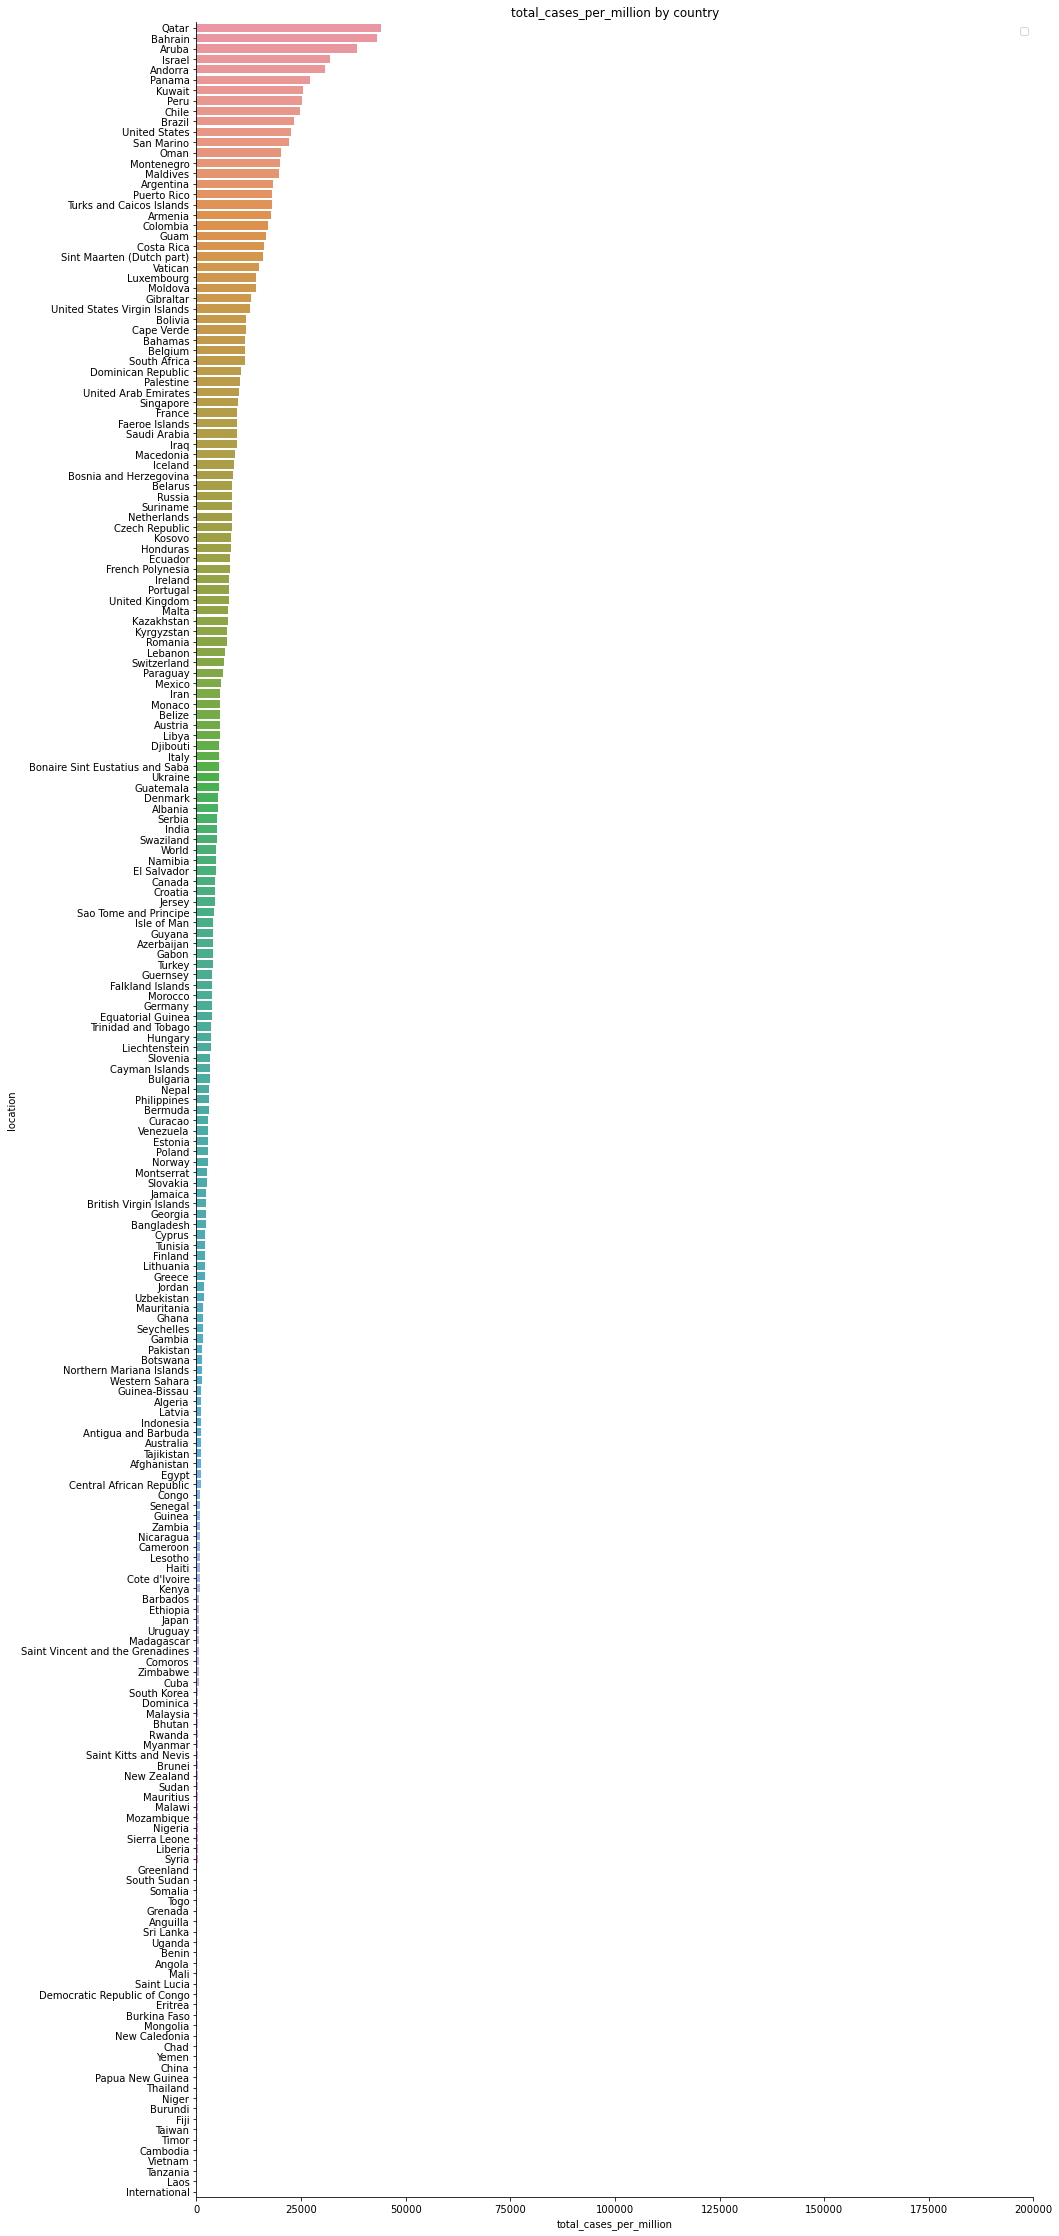

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=200000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


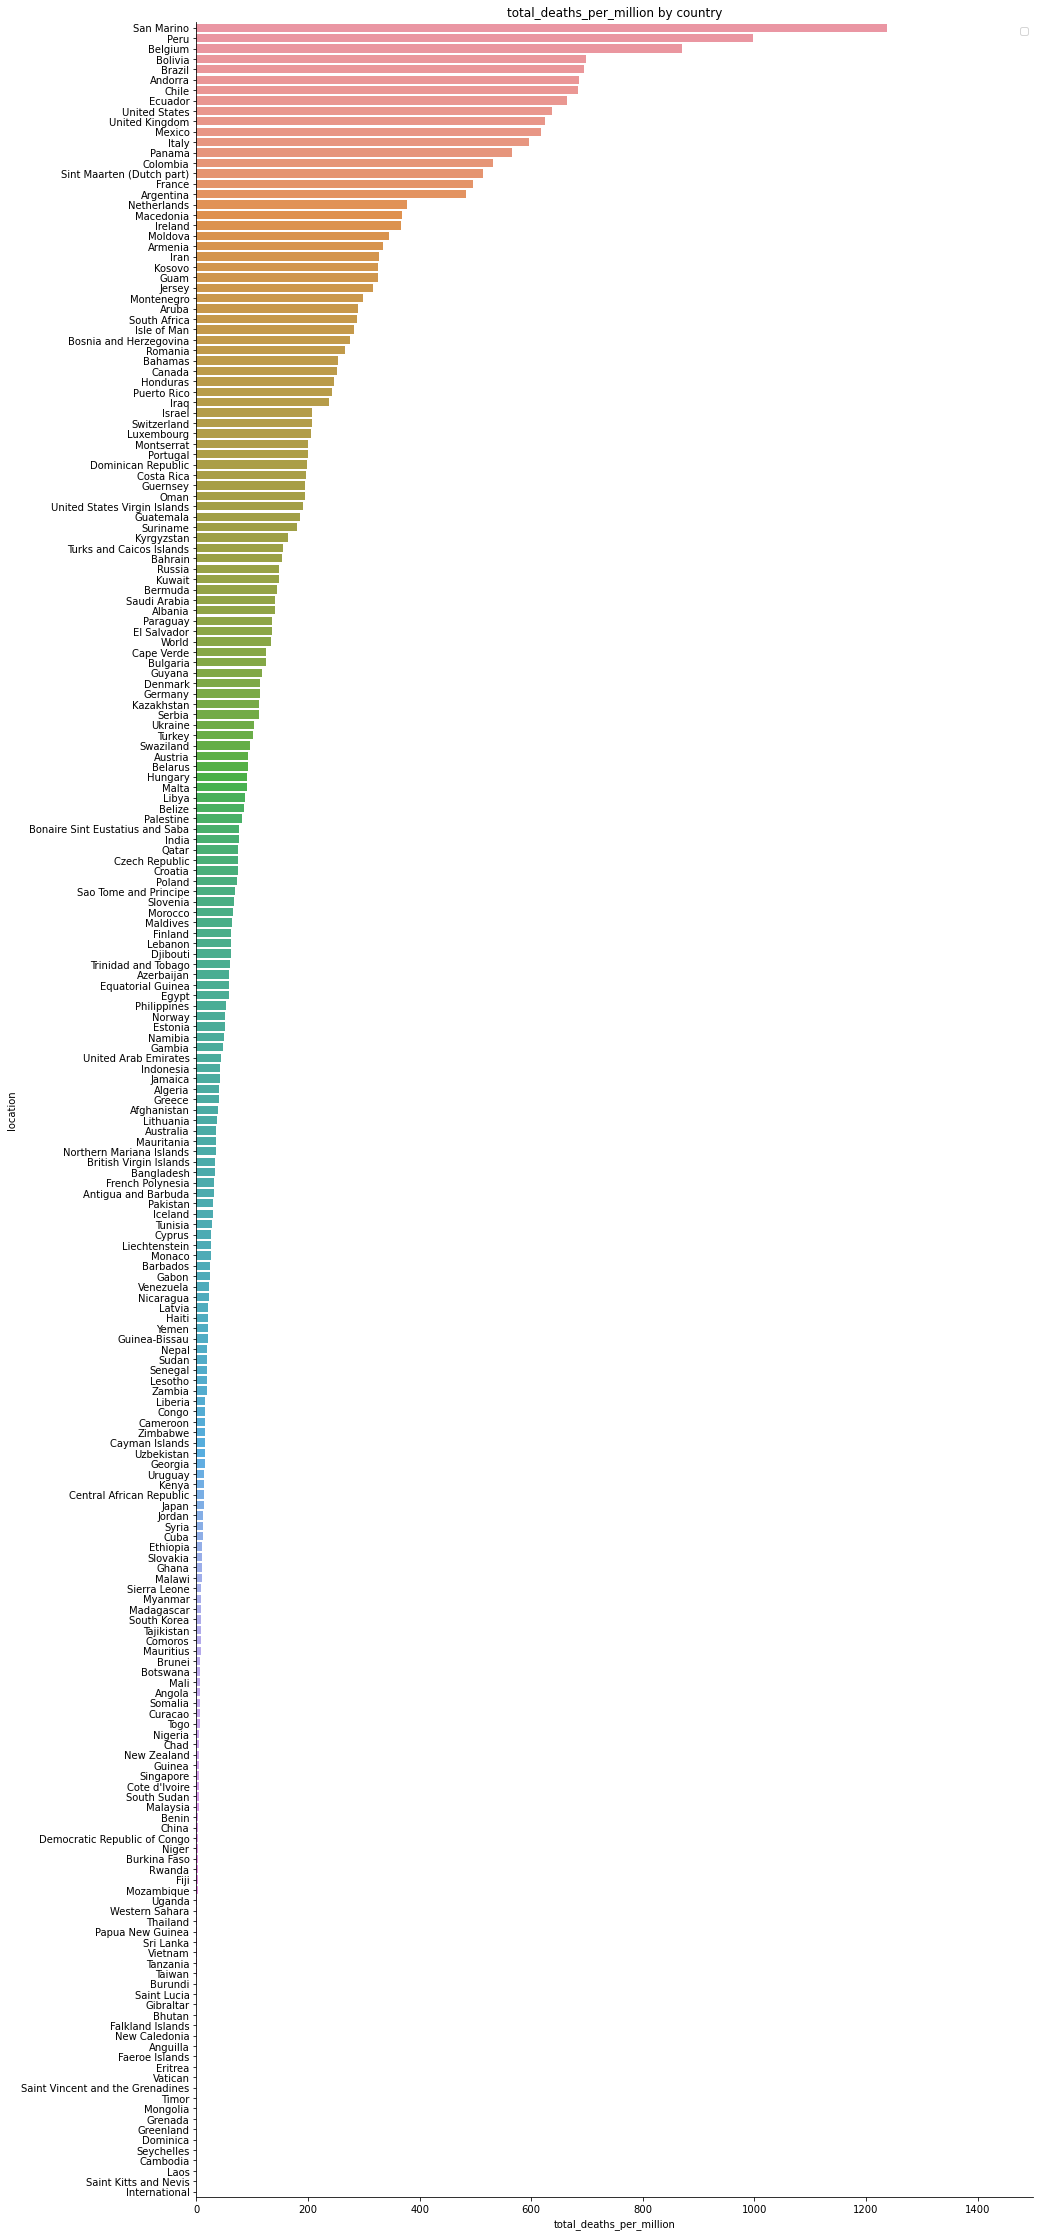

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

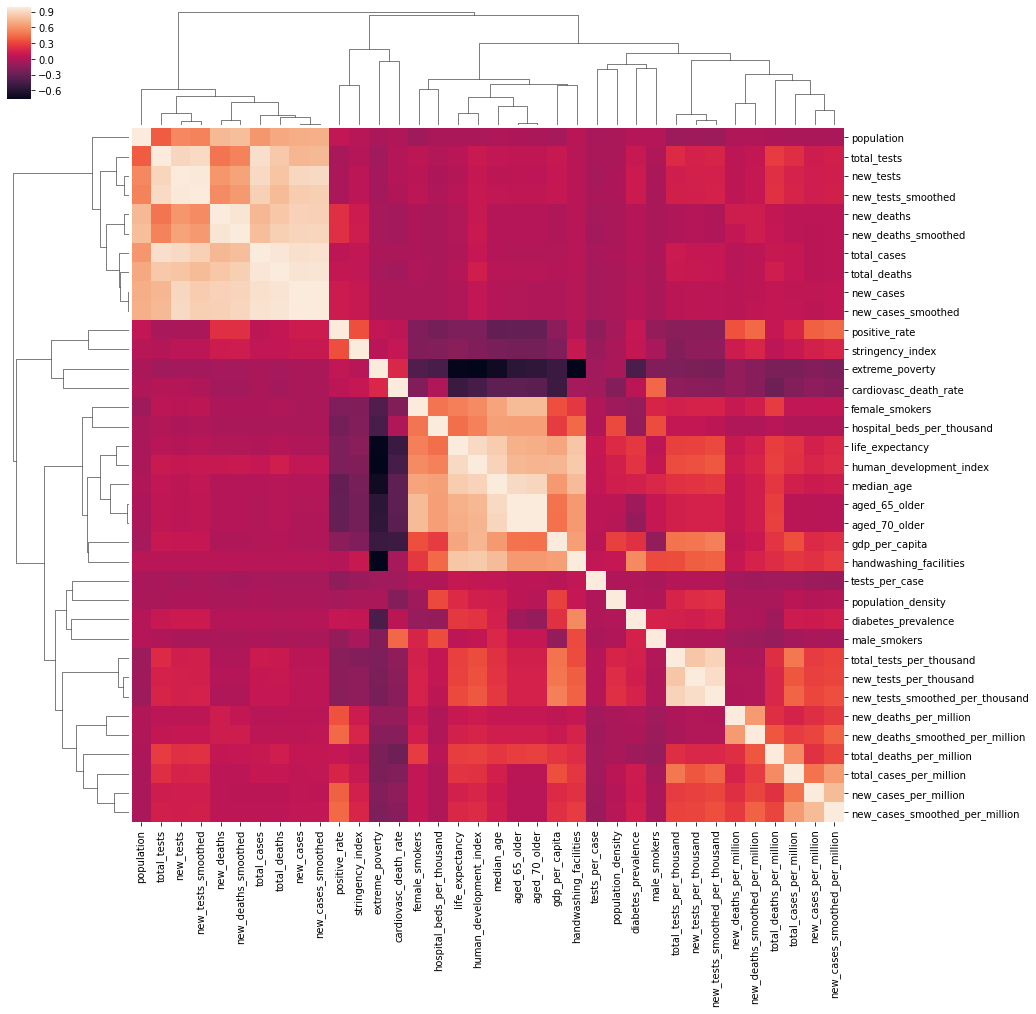

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"data\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9968455793569141 (+/- 0.004306342386780453)
Coef :  [1.02865524e+00 7.37476916e-05 7.63233099e-05]
3 Last_days :  [[35275845 35539466 35848254]]
Today :  35848254
Prediction + :  561336
Tomorow :  36409590
                                     
--------- Total Death -----------------
                                     
R^2: 0.9994915666428623 (+/- 0.00026405783140264974)
Coef :  [0.30846341 0.3406409  0.36057468]
3 Last_days :  [[1038208 1042658 1048181]]
Today :  1048181
Prediction + :  8950
Tomorow :  1057131
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8509642297707564 (+/- 0.2066696476281309)
Coef :  [-0.62441274  0.69236954  0.94044301]
3 Last_days :  [[619170 624274 634763]]
Today :  634763
Prediction + :  7634
Tomorow :  642397
                                     
--------- Total Death -----------------
                                     
R^2: 0.7410145442261088 (+/- 0.36048834090198956)
Coef :  [-0.7411731   0.78632755  0.95380414]
3 Last_days :  [[32230 32299 32365]]
Today :  32365
Prediction + :  69
Tomorow :  32434
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9777407946439932 (+/- 0.027571217983810382)
Coef :  [-0.3330377  -0.00476562  1.3320689 ]
3 Last_days :  [[90629 90652 90667]]
Today :  90667
Prediction + :  20
Tomorow :  90687
                                     
--------- Total Death -----------------
                                     
R^2: -3.6764341038163457 (+/- 6.496557642912525)
Coef :  [-0.07800897  0.01251233  1.05708838]
3 Last_days :  [[4739 4739 4739]]
Today :  4739
Prediction + :  4
Tomorow :  4743
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8422404477188983 (+/- 0.2217897285099315)
Coef :  [-0.80106606  0.88746362  0.9133134 ]
3 Last_days :  [[325329 327586 330263]]
Today :  330263
Prediction + :  1880
Tomorow :  332143
                                     
--------- Total Death -----------------
                                     
R^2: 0.9597831600004473 (+/- 0.043023096450148686)
Coef :  [-0.81405861  0.89252871  0.920469  ]
3 Last_days :  [[35986 36002 36030]]
Today :  36030
Prediction + :  30
Tomorow :  36060
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7505586843367241 (+/- 0.3402959403844533)
Coef :  [-0.19240682  0.16654018  1.03637834]
3 Last_days :  [[789932 813412 825410]]
Today :  825410
Prediction + :  13499
Tomorow :  838909
                                     
--------- Total Death -----------------
                                     
R^2: -0.9301632576868849 (+/- 2.4593598842986797)
Coef :  [-0.73093742  0.65100014  1.07907328]
3 Last_days :  [[32086 32225 32486]]
Today :  32486
Prediction + :  133
Tomorow :  32619
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8888693027561172 (+/- 0.15153621029613437)
Coef :  [0.22981065 0.38820383 0.39404937]
3 Last_days :  [[7417845 7458550 7501612]]
Today :  7501612
Prediction + :  76188
Tomorow :  7577800
                                     
--------- Total Death -----------------
                                     
R^2: 0.9673339670430233 (+/- 0.044881000339664204)
Coef :  [-0.30969895  0.6285165   0.68386685]
3 Last_days :  [[209794 210192 210909]]
Today :  210909
Prediction + :  996
Tomorow :  211905
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9366350746781417 (+/- 0.08705700214664336)
Coef :  [-0.79891996  0.83851774  0.96254713]
3 Last_days :  [[502978 515571 530113]]
Today :  530113
Prediction + :  10760
Tomorow :  540873
                                     
--------- Total Death -----------------
                                     
R^2: 0.9830186806919444 (+/- 0.011056052698234111)
Coef :  [-0.75785064  0.82782486  0.92921336]
3 Last_days :  [[42350 42369 42445]]
Today :  42445
Prediction + :  41
Tomorow :  42486
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7323263192987118 (+/- 0.37770520255490253)
Coef :  [-0.75826065  0.83961618  0.91899673]
3 Last_days :  [[300619 303258 306086]]
Today :  306086
Prediction + :  2199
Tomorow :  308285
                                     
--------- Total Death -----------------
                                     
R^2: 0.3330978469755313 (+/- 0.9370995733430476)
Coef :  [-0.77751717  0.83669859  0.93997757]
3 Last_days :  [[9534 9546 9562]]
Today :  9562
Prediction + :  14
Tomorow :  9576
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9966571584030793 (+/- 0.0034113720068581514)
Coef :  [0.45766014 0.27944288 0.275274  ]
3 Last_days :  [[471772 475674 479825]]
Today :  479825
Prediction + :  2809
Tomorow :  482634
                                     
--------- Total Death -----------------
                                     
R^2: 0.9088235143048619 (+/- 0.12772999303999277)
Coef :  [0.29711288 0.36393265 0.35116591]
3 Last_days :  [[26957 27192 27419]]
Today :  27419
Prediction + :  195
Tomorow :  27614
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9997641086990937 (+/- 0.00012079836192064287)
Coef :  [-0.52656705  0.75117404  0.77270581]
3 Last_days :  [[324443 326046 327557]]
Today :  327557
Prediction + :  1231
Tomorow :  328788
                                     
--------- Total Death -----------------
                                     
R^2: 0.9994587329127561 (+/- 0.00043387132014314247)
Coef :  [-0.80844733  0.89539935  0.91184496]
3 Last_days :  [[8441 8498 8553]]
Today :  8553
Prediction + :  48
Tomorow :  8601
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8309117993143875 (+/- 0.23129610098950407)
Coef :  [-0.08700577  0.50090203  0.59649051]
3 Last_days :  [[4915289 4927235 4969141]]
Today :  4969141
Prediction + :  45519
Tomorow :  5014660
                                     
--------- Total Death -----------------
                                     
R^2: 0.43354229737041833 (+/- 0.7929790695360487)
Coef :  [0.02193751 0.46320421 0.52390007]
3 Last_days :  [[146352 146675 147494]]
Today :  147494
Prediction + :  1323
Tomorow :  148817
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(35848254, 1048181, 36409590, 1057131),
 (634763, 32365, 642397, 32434),
 (330263, 36030, 332143, 36060),
 (825410, 32486, 838909, 32619),
 (7501612, 210909, 7577800, 211905),
 (90667, 4739, 90687, 4743),
 (530113, 42445, 540873, 42486),
 (306086, 9562, 308285, 9576),
 (479825, 27419, 482634, 27614),
 (327557, 8553, 328788, 8601),
 (4969141, 147494, 5014660, 148817)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-10-07,France,642397.0,0.0,32434.0,0.0,0.0,0.0
0,2020-10-07,China,90687.0,0.0,4743.0,0.0,0.0,0.0
0,2020-10-07,Italy,332143.0,0.0,36060.0,0.0,0.0,0.0
0,2020-10-07,Spain,838909.0,0.0,32619.0,0.0,0.0,0.0
0,2020-10-07,United States,7577800.0,0.0,211905.0,0.0,0.0,0.0
0,2020-10-07,World,36409590.0,0.0,1057131.0,0.0,0.0,0.0
0,2020-10-07,United Kingdom,540873.0,0.0,42486.0,0.0,0.0,0.0
0,2020-10-07,Germany,308285.0,0.0,9576.0,0.0,0.0,0.0
0,2020-10-07,Iran,482634.0,0.0,27614.0,0.0,0.0,0.0
0,2020-10-07,Turkey,328788.0,0.0,8601.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"data\\Pred\\predDf{date.today()}.csv")